In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import monpa
import jieba.analyse
import codecs
import operator
import nltk

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


## 法一：先合併df再切成series再轉成list

In [2]:
covid19_china = pd.read_csv("./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/中時/COVID-19_cleaned 中時.csv", encoding = 'utf-8')
covid19_china.head()

,CATEGORY,TITLE,cleaned_text,FROM,TIME
0,0,史話》亞裔不再做啞裔（一）,史話 亞裔 啞裔 編按 底 新冠 疫情 全球 開始 流行 加上 美國 總統 激化 亞裔 仇視...,中時新聞網,2021-12-22 00:00:00
1,1,MLB》漢克阿倫施打新冠疫苗 呼籲大家跟進,MLB 漢克阿倫 施打 新冠 疫苗 呼籲 美國 職棒 傳奇 漢克阿倫 ( Hank Aaro...,中時新聞網,2021-01-06 11:02:38
2,2,轄區確診者最多 苗縣消防第2大隊全員打疫苗,轄區 確診 苗縣 消防 全 員 疫苗 苗栗縣 昨天 累計 名 武漢 肺炎 確診 均 消防局 ...,中時新聞網,2021-05-28 14:35:34
3,3,陳時中掛保證 500萬劑莫德納疫苗年中到貨,陳時中 掛 保證 劑 莫德納 疫苗 美國 莫德納公司 宣布 出售 劑 新冠 疫苗 台灣 衛福...,中時新聞網,2021-02-10 10:10:12
4,4,羅列謀獨三大罪狀 痛批難逃歷史審判 嗆算台獨總帳 陸官媒點名蘇揆,羅列謀 獨三 罪狀 痛批 難逃 歷史 審判 嗆 算 台獨 總帳 陸官媒 點名 蘇揆 機關報 ...,中時新聞網,2020-11-20 04:10:00


In [3]:
covid19_free = pd.read_csv("./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/自由/COVID-19_cleaned 自由.csv", encoding = 'utf-8')
covid19_free.head()

,CATEGORY,TITLE,cleaned_text,FROM,TIME
0,0,某國小赴蘭嶼校外教學1生確診107人困當地 新北市府稱協調東縣接回,國小 赴 蘭嶼 校 外 教學 生 確診 困當地 新北市府 稱 協調 東縣 接回 新北市 累計...,自由時報,2022-04-20 17:23:05
1,1,桃園新街國小昨增3確診 師生40天內二度採檢好無奈,桃園 新街 國小 昨 增 確診 師生 天 二 度 採檢 新街 國小 學童 確診 校方 緊急 ...,自由時報,2022-03-01 10:33:28
2,2,上海又一神操作！舉辦抗疫慶功晚會被罵翻 臨時取消,神 操作 舉辦 抗 疫慶功 晚會 罵 翻 取消 疫情 嚴重 實施 封控 民怨 四 美聯社 〔...,自由時報,2022-04-13 06:51:18
3,3,恐達33萬例！南韓連2天單日速增17萬確診,恐 達 例 南韓 天 單日 速增 確診 南韓 民眾 首爾 處 採檢站 排隊 篩檢 歐新社 〔...,自由時報,2022-02-24 09:47:04
4,4,單日1500例才啟動居家照護太慢 侯友宜：相信中央會盡快,單日 例 啟動 居家 太 慢 侯友宜 相信 新北 市長 侯友宜 呼籲 啟動 居家 醫療量 衝...,自由時報,2022-04-10 12:13:22


In [4]:
covid19_new = pd.concat([covid19_china, covid19_free], axis = 0)
covid19_new = covid19_new.drop("CATEGORY", axis = 1)
covid19_new = covid19_new.rename_axis('index').reset_index()
covid19_new = covid19_new.drop("index", axis = 1)
covid19_new

,TITLE,cleaned_text,FROM,TIME
0,史話》亞裔不再做啞裔（一）,史話 亞裔 啞裔 編按 底 新冠 疫情 全球 開始 流行 加上 美國 總統 激化 亞裔 仇視...,中時新聞網,2021-12-22 00:00:00
1,MLB》漢克阿倫施打新冠疫苗 呼籲大家跟進,MLB 漢克阿倫 施打 新冠 疫苗 呼籲 美國 職棒 傳奇 漢克阿倫 ( Hank Aaro...,中時新聞網,2021-01-06 11:02:38
2,轄區確診者最多 苗縣消防第2大隊全員打疫苗,轄區 確診 苗縣 消防 全 員 疫苗 苗栗縣 昨天 累計 名 武漢 肺炎 確診 均 消防局 ...,中時新聞網,2021-05-28 14:35:34
3,陳時中掛保證 500萬劑莫德納疫苗年中到貨,陳時中 掛 保證 劑 莫德納 疫苗 美國 莫德納公司 宣布 出售 劑 新冠 疫苗 台灣 衛福...,中時新聞網,2021-02-10 10:10:12
4,羅列謀獨三大罪狀 痛批難逃歷史審判 嗆算台獨總帳 陸官媒點名蘇揆,羅列謀 獨三 罪狀 痛批 難逃 歷史 審判 嗆 算 台獨 總帳 陸官媒 點名 蘇揆 機關報 ...,中時新聞網,2020-11-20 04:10:00
...,...,...,...,...
30605,謠言終結站》伊維菌素可以有效對抗Omicron變種病毒？,謠言 終結 站 伊維菌素 Omicron 變種 病毒 謠言 終結 站 網傳 消息 近日 社群...,自由時報,2022-02-06 05:30:00
30606,防疫情蔓延 Google要求美國員工每週篩檢,防疫情 蔓延 Google 美國 員工 週 篩檢 Google 進入 辦公室 員工 週 進行...,自由時報,2022-01-15 15:36:00
30607,元旦歐洲武肺累計確診破億例 外媒：占全球逾1/3,元旦 歐洲 武肺 累計 確診 破 億 例 外媒 占 全球 逾 武漢 肺炎 新型 冠狀 病毒病...,自由時報,2022-01-02 13:00:28
30608,神隱10天終於現身！英相強森：謹慎歡慶新年 快去打加強針,神隱 天 終於 現身 英相 強森 謹慎 歡慶 新年 快 加強 針 變種 病毒 Omicron...,自由時報,2021-12-29 23:26:11


## 法二：合併之後另存新檔再轉成list

In [ ]:
covid19_new.to_csv('./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/covid19.csv', header = True, index = False, encoding="utf-8")

In [ ]:
covid19 = pd.read_csv('./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/covid19.csv', encoding = 'utf-8')
covid19

In [5]:
covid19 = covid19_new['cleaned_text'].values.tolist()
type(covid19)

list

In [6]:
covid19[0]

'史話 亞裔 啞裔 編按 底 新冠 疫情 全球 開始 流行 加上 美國 總統 激化 亞裔 仇視 開始 升溫 作者 江青 新作 念念 親身 記錄 省思 疫情 反亞裔 情緒 書 出版 史話 專欄 節選 刊登 寫 紐約 旬 終於 排除 萬難 瑞典 回到 紐約 探望 歲 母親 身體 欠妥 急診 探望 前 晚 浴室 摔斷 根 肋骨 疼痛 難當 分離 月 聚有如隔世 擁抱 相視 微笑 天 母親 住處 陪 談 家常 煮 點 菜 調整 藥 周 血壓 開始 回復 正常 胃口 先前 精氣神 顯而易見 天 天 進步 青霞 微信 孝順 孝 疫情 孤寂 影響 精神 健康 狀況 親情 良藥 注意到 紐約 蕭條 關門 零 星星 客人 餐館 歇業 冷 清清 店舖 黑漆漆 辦公 空蕩蕩 燈火 熄滅 林肯 黑洞 頓時 心 空 塊 眼前 見 蘋果 ─ ─ 紐約 令 心碎 疫情 朋友 見面 電話 聊天 話題 接種 疫苗 亞裔 安全 問題 知情 注意 媒體 報導 瞭解 仇恨 亞裔 火苗 全 美國 燃燒 寫 篇 投訴 陪 媽媽 老人中心 早餐 莫名其妙 羞辱 番 節錄 片段 諾大 食堂 客滿 意識到 亞洲人 遠 男士 走 問 坐 點頭 早餐 談天 半 男士 突然 問 妳 點頭 妳 請 桌 嘰哩咕嚕 外國 話 完全 懂得 尊重 剛剛 歐洲 回來 媽媽 久 沒有 見 …… 回到 繼續 妳 懂 回到 美國 近 頭 聽到 蠻 講理 豈 話 美國 重要 … … 站起來 餐盤 弄得 通通響 甩 椅子 揚長 決定 老人中心 辦公室 投訴 促使 投訴 原因 感到 川普任 總統 明顯 感到 移民 難民 弱勢 群體 欺壓 社會 白人 美國 優先 類 口吻 現象 越 趨 嚴重 投訴 負責人 請教 『 美國 重要 』 句 話 什麼 意思 清楚 川普 支持者 川普 移民 政策 妳 知道 搞 分裂 現在 特別 重視 製造 分裂 尊重 扭曲 現象 絕不 容忍 姑且 歧視 敗類 愚昧 …… 負責人 振振有辭 理直氣壯 文章 句 告訴 負責人 美國 投訴 希望 目前 現象 願望 背道而馳 忍無可忍 投訴 演 變成 控訴 春天 疫情 開始 疫情 掀起 族主義 仇恨 源頭 美國 歷史 固有 部分 日 趨 嚴重 原因 民眾 美 激烈 競爭 前提 敵意 嫉恨 情緒 避免 加大 前 總統 川普火 澆油 場 疫情 武漢 病毒 功夫 流感 類 詛咒性 字眼

In [11]:
import nltk
all = []
word = []
stop_word=['表示','進行',')','(','記者','【', '】',"天","表示",'……','抽','天天中獎','報導','現在','活動', '〔', 
           '〕', '%', '％', '月', '沒','外', '未', '約', '元', '應', '新', '-', '國', '高', '歲', '全', '家', 
           '請', '例', '劑', '日', '名', '前', '案', '目前', '新增', '沒有', '出現', '相關', '持續', '工作', '結果',
          '接種', '指出', '施打', '提供', '接觸']
for i in range(len(covid19)):
    word = covid19[i].split(' ')
    for j in range(len(word)):
         if word[j] not in stop_word:
            all.append(word[j])
all

['史話',
 '亞裔',
 '啞裔',
 '編按',
 '底',
 '新冠',
 '疫情',
 '全球',
 '開始',
 '流行',
 '加上',
 '美國',
 '總統',
 '激化',
 '亞裔',
 '仇視',
 '開始',
 '升溫',
 '作者',
 '江青',
 '新作',
 '念念',
 '親身',
 '記錄',
 '省思',
 '疫情',
 '反亞裔',
 '情緒',
 '書',
 '出版',
 '史話',
 '專欄',
 '節選',
 '刊登',
 '寫',
 '紐約',
 '旬',
 '終於',
 '排除',
 '萬難',
 '瑞典',
 '回到',
 '紐約',
 '探望',
 '母親',
 '身體',
 '欠妥',
 '急診',
 '探望',
 '晚',
 '浴室',
 '摔斷',
 '根',
 '肋骨',
 '疼痛',
 '難當',
 '分離',
 '聚有如隔世',
 '擁抱',
 '相視',
 '微笑',
 '母親',
 '住處',
 '陪',
 '談',
 '家常',
 '煮',
 '點',
 '菜',
 '調整',
 '藥',
 '周',
 '血壓',
 '開始',
 '回復',
 '正常',
 '胃口',
 '先前',
 '精氣神',
 '顯而易見',
 '進步',
 '青霞',
 '微信',
 '孝順',
 '孝',
 '疫情',
 '孤寂',
 '影響',
 '精神',
 '健康',
 '狀況',
 '親情',
 '良藥',
 '注意到',
 '紐約',
 '蕭條',
 '關門',
 '零',
 '星星',
 '客人',
 '餐館',
 '歇業',
 '冷',
 '清清',
 '店舖',
 '黑漆漆',
 '辦公',
 '空蕩蕩',
 '燈火',
 '熄滅',
 '林肯',
 '黑洞',
 '頓時',
 '心',
 '空',
 '塊',
 '眼前',
 '見',
 '蘋果',
 '─',
 '─',
 '紐約',
 '令',
 '心碎',
 '疫情',
 '朋友',
 '見面',
 '電話',
 '聊天',
 '話題',
 '疫苗',
 '亞裔',
 '安全',
 '問題',
 '知情',
 '注意',
 '媒體',
 '瞭解',
 '仇恨',
 '亞裔',
 '火苗',
 '美國',
 '燃燒',
 '寫',
 '篇',


In [12]:
fdist = nltk.FreqDist(all)
fdist.most_common(30)

[('疫苗', 95686),
 ('疫情', 60400),
 ('確診', 42791),
 ('病毒', 35413),
 ('防疫', 31828),
 ('新冠', 26630),
 ('感染', 24457),
 ('民眾', 23537),
 ('肺炎', 21730),
 ('台灣', 21296),
 ('Omicron', 18603),
 ('美國', 18064),
 ('隔離', 16592),
 ('症狀', 14984),
 ('採檢', 14913),
 ('病例', 14906),
 ('Delta', 14878),
 ('指揮中心', 14749),
 ('口罩', 12914),
 ('政府', 12860),
 ('COVID', 12031),
 ('措施', 11979),
 ('風險', 11762),
 ('國家', 11158),
 ('全球', 11123),
 ('醫院', 11017),
 ('死亡', 9586),
 ('社區', 9461),
 ('流行', 9386),
 ('AZ', 9310)]

In [13]:
stopwords = {}.fromkeys([")","(","天","表示",'記者','抽','天天中獎','報導','現在','活動', '-', '未', '元', '沒', '點', '外', '約'])

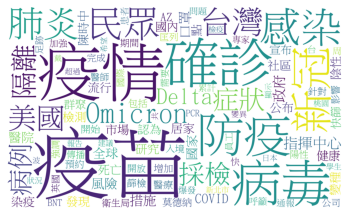

<Figure size 1000x600 with 0 Axes>

In [14]:
def generate_wordcloud(keywords, stopwords, file_path):
    wc = WordCloud(font_path = "./TW-Sung-98_1.ttf",
                   background_color = "white",
                   max_words = 100, stopwords = stopwords,
                   width=2000, height=1200)
    
    wc.generate_from_frequencies(keywords)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize = (10, 6), dpi = 100)
    plt.show()
    wc.to_file('./文字雲/covid19.jpg')

# def get_keywords(file_path, topN):
#     keywords = {}
#     with open(file_path, "r", encoding = "utf-8") as f:
#         corpus = ""
#         for line in f:
#             corpus = f'{corpus}{" ".join(monpa.cut(line))}'
#         tags = jieba.analyse.extract_tags(corpus, topK = topN, withWeight = True)
#         for tag, weight in tags:
#             keywords[tag] = weight
#     return keywords

# keywords = get_keywords('./covid19.txt', 30)
# print(keywords)
x = generate_wordcloud(fdist, stopwords, "./covid19_wordcloud.jpg")